In [2]:
def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [120]:
# plot csv file
import matplotlib as mpl
# Use the pgf backend (must be set before pyplot imported)
mpl.use('pgf')
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False     # don't setup fonts from rc parameters
    })

# Load the CSV file
data = pd.read_csv(r'4\102mA\Broad.csv')

# Clean the column names by removing commas
data.columns = [col.replace(',', '') for col in data.columns]

# Convert the data to numeric values (removing commas in data)
data = data.replace({',': ''}, regex=True).apply(pd.to_numeric)

# Select the series with column name '20000'
series_column = '20000'
series_data = data[series_column]
limit = 600

# Plot the original series
plt.figure(figsize=set_size(469))
plt.plot(series_data)
plt.xlabel('Counts (a.u.)')
plt.ylabel('Values (a.u.)')
plt.title(f'FPI Data')
plt.grid(True)
plt.xlim(-10, limit)
plt.savefig(r'Latex\Figures\FPI_Data.pgf', format='pgf')
plt.show()

# Flip the data about the x-axis
flipped_series_data = -series_data

# Normalize the flipped data
normalized_flipped_series_data = (flipped_series_data) / (flipped_series_data.max())

# Find peaks in the flipped normalized series
peaks, _ = find_peaks(normalized_flipped_series_data, height = 0.1)

# Calculate distances between consecutive peaks
peak_distances = np.diff(peaks)

# Plot the flipped normalized series with peaks highlighted
fig, ax = plt.subplots(figsize=set_size(469))
ax.plot(normalized_flipped_series_data)
ax.plot(peaks, normalized_flipped_series_data[peaks], 'o', label='Peaks')
ax.set_xlabel('Counts (a.u.)')
ax.set_ylabel(r'$\frac{I}{I_{max}}$', rotation='horizontal', labelpad=15, fontsize=14)
ax.set_title(f'Flipped and Normalized FPI Peaks')

# Annotate the peaks
for peak in peaks:
    ax.annotate(peak, (peak, normalized_flipped_series_data[peak]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, rotation=0)

ax.legend()
ax.grid(True)
ax.set_xlim(-10, limit)
plt.savefig(r'Latex\Figures\FPI_Peaks.pgf', format='pgf')
plt.show()

# Compute the average distance between peaks in the filtered array
average_peak_distance = np.mean(peak_distances)
GHz_per_index = 1/ average_peak_distance
print(f'Average distance between peaks: {average_peak_distance}')
print(f'GHz per index: {GHz_per_index}')

# Compute the x-values in GHz
x_values_GHz = np.arange(len(normalized_flipped_series_data)) * GHz_per_index

# Plot the flipped normalized series with peaks highlighted
fig, ax = plt.subplots(figsize=set_size(469))
ax.plot(x_values_GHz, normalized_flipped_series_data)
ax.plot(peaks * GHz_per_index, normalized_flipped_series_data[peaks], 'o', label='Peaks')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel(r'$\frac{I}{I_{max}}$', rotation='horizontal', labelpad=15, fontsize=16)
ax.set_title(f'Flipped and Normalized FPI Peaks')

# Annotate the peaks
for peak in peaks:
    ax.annotate(f'{peak * GHz_per_index:.2f}', (peak * GHz_per_index, normalized_flipped_series_data[peak]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, rotation=0)

ax.legend()
ax.grid(True)
ax.set_xlim(-10 * GHz_per_index, limit * GHz_per_index)
plt.savefig(r'Latex\Figures\FPI_Peaks_GHz.pgf', format='pgf')
plt.show()


# Define the Lorentzian function with an amplitude parameter
def lorentzian(x, x0, dv, C, y0):
    return  y0 + (2*C/np.pi)*(dv / (4*(x - x0)**2 + (dv)**2))

peak_index = peaks[1]
window_size = 10 # Adjust as needed
window_indices = range(max(0, peak_index - window_size), min(len(normalized_flipped_series_data), peak_index + window_size + 1))
window_x = x_values_GHz[window_indices]
window_y = normalized_flipped_series_data[window_indices]

# Initial parameter estimates
x0_initial = x_values_GHz[peak_index]  # center frequency of the peak
gamma_initial = 0.1  # width of the peak
C_initial = max(window_y)  # height of the peak
y0_initial = normalized_flipped_series_data.min()  # offset

# Now you can use A_initial in your initial parameter estimates
p0 = [x0_initial, gamma_initial, C_initial, y0_initial]

fit_options = {'maxfev': 10000}

# Fit the Lorentzian function to the data in the window
popt, _ = curve_fit(lorentzian, window_x, window_y, p0=p0)

# Calculate the R^2 score for the original fit
predicted_y = lorentzian(window_x, *popt)
r2 = r2_score(window_y, predicted_y)


# Plot the original data and the fitted function for the window only
fig, ax = plt.subplots(figsize=set_size(469))
ax.plot(window_x, window_y, 'b-', label='data')
ax.plot(window_x, predicted_y, 'r-', label=r'fit: $\delta \nu$=%5.6f, $R^2$=%5.3f' % (popt[1], r2))
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel(r'$\frac{I}{I_{max}}$', rotation='horizontal', labelpad=15, fontsize=16)
ax.set_title(f'Fitted Lorentzian')
ax.legend()
ax.grid(True)
plt.show()

# Generate high-resolution x-values
high_res_x = np.linspace(window_x.min(), window_x.max(), 1000)

# Calculate the corresponding y-values using the fitted parameters
high_res_y = lorentzian(high_res_x, *popt)

# Plot the original data and the high-resolution fitted function
fig, ax = plt.subplots(figsize=set_size(469))
ax.plot(window_x, window_y, 'b-', label='data')
ax.plot(high_res_x,high_res_y, 'r-', label=r'fit: $\delta \nu$=%5.6f, $R^2$=%5.3f' % (popt[1], r2))
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel(r'$\frac{I}{I_{max}}$', rotation='horizontal', labelpad=15, fontsize=16)
ax.set_title(f'Fitted Lorentzian')
ax.legend()
ax.grid(True)
plt.savefig(r'Latex\Figures\FPI_Fit.pgf', format='pgf')
plt.show()

print('R^2=', r2)
print('dv', popt[1])
print('Finesse', 1/popt[1])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18176\4000959611.py:41: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18176\4000959611.py:71: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Average distance between peaks: 56.15277777777778
GHz per index: 0.017808558001484048
R^2= 0.9972400457626476
dv 0.004764306358910235
Finesse 209.89414295950843


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18176\4000959611.py:98: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18176\4000959611.py:139: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18176\4000959611.py:157: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


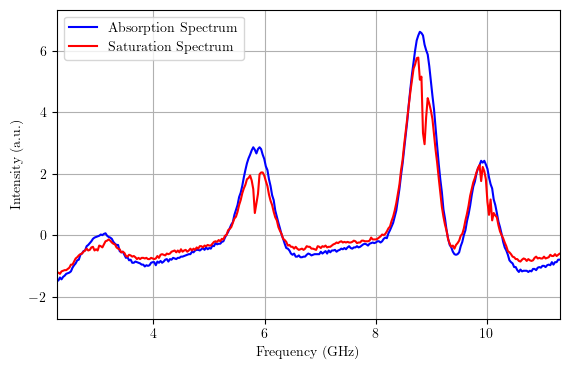

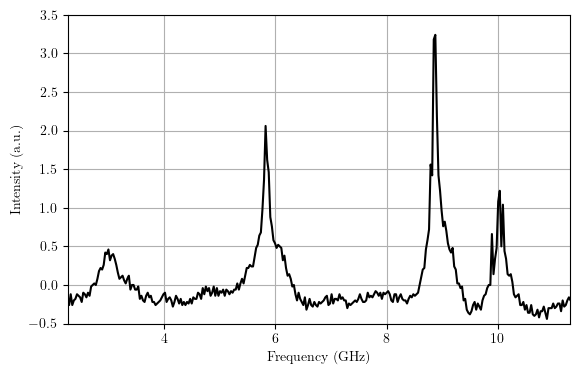

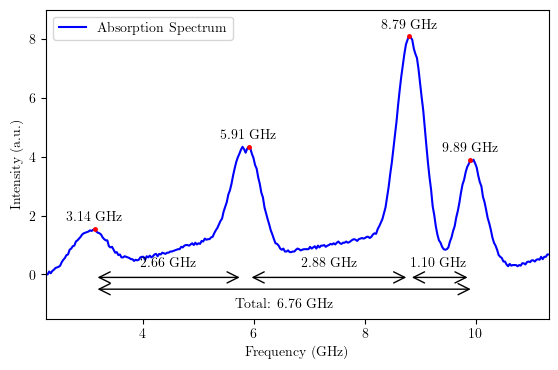

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
from matplotlib.patches import FancyArrowPatch
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False     # don't setup fonts from rc parameters
    })

# Load the CSV files
data1 = pd.read_csv(r'4\102mA\Broad.csv')
data2 = pd.read_csv(r'4\102mA\BroadBlocked.csv')

# Clean the column names by removing commas
data1.columns = [col.replace(',', '') for col in data1.columns]
data2.columns = [col.replace(',', '') for col in data2.columns]

# Convert the data to numeric values (removing commas in data)
data1 = data1.replace({',': ''}, regex=True).apply(pd.to_numeric)
data2 = data2.replace({',': ''}, regex=True).apply(pd.to_numeric)

# Select the series with column name '20000'
series_column1 = '-50000'
series_column2 = '-84000'
series_data1 = data1[series_column1]
series_data2 = data2[series_column2]
limit = 400

# Convert the index to GHz
GHz_per_index = 0.017808558001484048/0.63
series_data1.index = series_data1.index * GHz_per_index
series_data2.index = series_data2.index * GHz_per_index
series_data1 = series_data1/100000
series_data2 = series_data2/100000

# Plot the original series
plt.figure(figsize=set_size(469))
plt.plot(series_data2, label='Absorption Spectrum', color='blue')
plt.plot(series_data1, label='Saturation Spectrum', color='red')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Intensity (a.u.)')
#plt.title('FPI Data')
plt.xlim(80*GHz_per_index, limit*GHz_per_index)
plt.grid(True)
plt.legend()
#plt.savefig(r'Latex\Figures\FPI_Data.pgf', format='pgf')
plt.show()

# Plot the difference between then

plt.figure(figsize=set_size(469))
plt.plot(series_data2 - series_data1, color='black')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Intensity (a.u.)')
#plt.title('FPI Data')
plt.xlim(80*GHz_per_index, limit*GHz_per_index)
plt.ylim(-0.5, 3.5)
plt.grid(True)
#plt.savefig(r'Latex\Figures\FPI_Data.pgf', format='pgf')
plt.show()

# Define the x-limits
x_lower_limit = 80*GHz_per_index
x_upper_limit = limit*GHz_per_index

# Select the data within the x-limits
selected_data = series_data2[(series_data2.index >= x_lower_limit) & (series_data2.index <= x_upper_limit)]
selected_data = selected_data - selected_data.min()

# Find the peaks
peaks, _ = find_peaks(selected_data, distance=2, prominence=1)

# Calculate the distances between the peaks
peak_distances = np.diff(peaks)

# Plot the selected data
plt.figure(figsize=set_size(469))
plt.plot(selected_data.index, selected_data, label='Absorption Spectrum', color='blue')

# Plot the peaks
for i in range(len(peaks) - 1):
    if i != 1:  # Skip the second peak
        plt.plot(selected_data.index[peaks[i]], selected_data.iloc[peaks[i]], ".", markersize=5, color='red')

# Annotate the distances between the peaks
for i in range(len(peaks) - 1):
    if i == 1:  # Skip the second peak
        continue
    if peak_distances[i] > 10:
        plt.annotate(f'{peak_distances[i] * GHz_per_index:.2f} GHz', 
                     ((selected_data.index[peaks[i]] + selected_data.index[peaks[i + 1]]) / 2, 0), 
                     textcoords="offset points", xytext=(0, 5), ha='center')
        arrow = FancyArrowPatch((selected_data.index[peaks[i]], -0.1), (selected_data.index[peaks[i + 1]], -0.1), 
                                arrowstyle='<->', mutation_scale=20)
        plt.gca().add_patch(arrow)
    plt.annotate(f'{selected_data.index[peaks[i]]:.2f} GHz', 
                 (selected_data.index[peaks[i]], selected_data.iloc[peaks[i]]), 
                 textcoords="offset points", xytext=(0, 5), ha='center')

# Calculate total distance between first and last peak
total_distance = selected_data.index[peaks[-2]] - selected_data.index[peaks[0]]

# Annotate the total distance
plt.annotate(f'Total: {total_distance:.2f} GHz', 
             ((selected_data.index[peaks[0]] + selected_data.index[peaks[-1]]) / 2, 0), 
             textcoords="offset points", xytext=(0, -25), ha='center')

# Add an arrow for total distance
total_distance_arrow = FancyArrowPatch((selected_data.index[peaks[0]], -0.5), (selected_data.index[peaks[-1]], -0.5), 
                                       arrowstyle='<->', mutation_scale=20)
plt.gca().add_patch(total_distance_arrow)

plt.xlabel('Frequency (GHz)')
plt.ylabel('Intensity (a.u.)')
plt.xlim(selected_data.index[0], selected_data.index[-1])
plt.ylim(-1.5, 9)

plt.legend()
plt.show()
